# Spectral analysis code

Spectral analysis of high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 31/08/2024

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import os, h5py, time, gc
import tqdm
import scipy.integrate
from joblib import Parallel, delayed
%matplotlib widget

## Import images

In [2]:
# data to analyse
filename="/Users/dduke/Desktop/sampleImaging/mountPoint_extinction.h5"

SPATIAL_RES=1
SAMPLE_RATE=1e5

In [3]:
print("Loading",filename)
with h5py.File(filename,'r') as H:
    for G in H.values():
        if isinstance(G,h5py.Group):
            t = G['time_frames'][...]
            x = G['x_pixel'][...]
            y = G['y_pixel'][...]
            b = G['bkgnd'][...]
            if 'SPATIAL_RES' in G.attrs: SPATIAL_RES = G.attrs['SPATIAL_RES']
            if 'SAMPLE_RATE' in G.attrs: SAMPLE_RATE = G.attrs['SAMPLE_RATE']
            print("    ",G.name," - size of data:",G['I'].shape)

            if '40000' in G.name:
                data = G['I'][...]
                break # take one data set only

print("Loaded", data.shape, data.dtype)

Loading /Users/dduke/Desktop/sampleImaging/mountPoint_extinction.h5
     /frames_28348_39999  - size of data: (11651, 416, 256)
     /frames_40000_69999  - size of data: (29999, 416, 256)
Loaded (29999, 416, 256) float32


## Flip / rotate images
This step should be customised depending on the camera orientation
For example, rotation could be required in some cases.

In [4]:
# Flip all the images so the spray is L->R
#data = np.flip(data,axis=2)
#b = np.flip(b,axis=1) # same to background so it plots the same

# Rotate the images
data = np.swapaxes(data,1,2);
b = np.transpose(b);

gc.collect();

## Masking unwanted regions of the image

In [ ]:
import scipy.ndimage.morphology

# Mask dark regions of background
mask = 1 - scipy.ndimage.morphology.binary_dilation(b < 10000, iterations=1)
plt.figure();
plt.imshow(mask,cmap='grey');
plt.title("Mask");

In [ ]:
# Permanently apply the mask
for i in tqdm.tqdm(range(data.shape[0])):
    data[i,...] = data[i,...] * mask

## Check sample images
Check masking and intensity range are sane

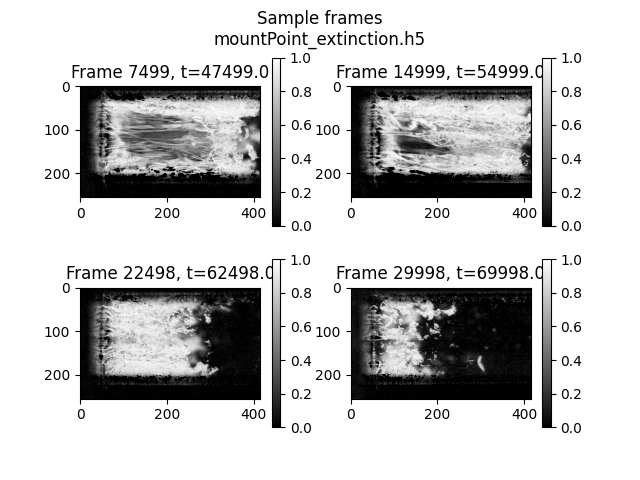

In [5]:
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(filename))
some_frames = np.linspace(0,data.shape[0]-1,5)[1:]; i=0
for n in some_frames:
    ax=fig.add_subplot(221+i)
    h=ax.imshow(data[int(n),...],cmap=plt.cm.gray,vmin=0,vmax=1)
    plt.title("Frame %i, t=%.1f" % (n,t[int(n)]))
    plt.colorbar(h);
    i+=1
gc.collect();

## Calculate temporal statistics
Get time-average image, etc, which will be useful later on.

In [6]:
# This manual way uses far less memory, and is faster, than NumPy's approach.
timeAvImg = np.zeros_like(data[0,...])
meansqImg  = np.zeros_like(data[0,...])
N = float(data.shape[0])
for i in tqdm.tqdm(range(int(N))): # Single CPU
    timeAvImg += data[i,...]/N
    meansqImg += (data[i,...]**2)/N
stdevImg = np.sqrt(meansqImg - timeAvImg**2)

# Inefficient for very large data...:
#timeAvImg = np.nanmean(data,axis=0)
#stdevImg = np.nanstd(data,axis=0)

100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:43<00:00, 695.61it/s]


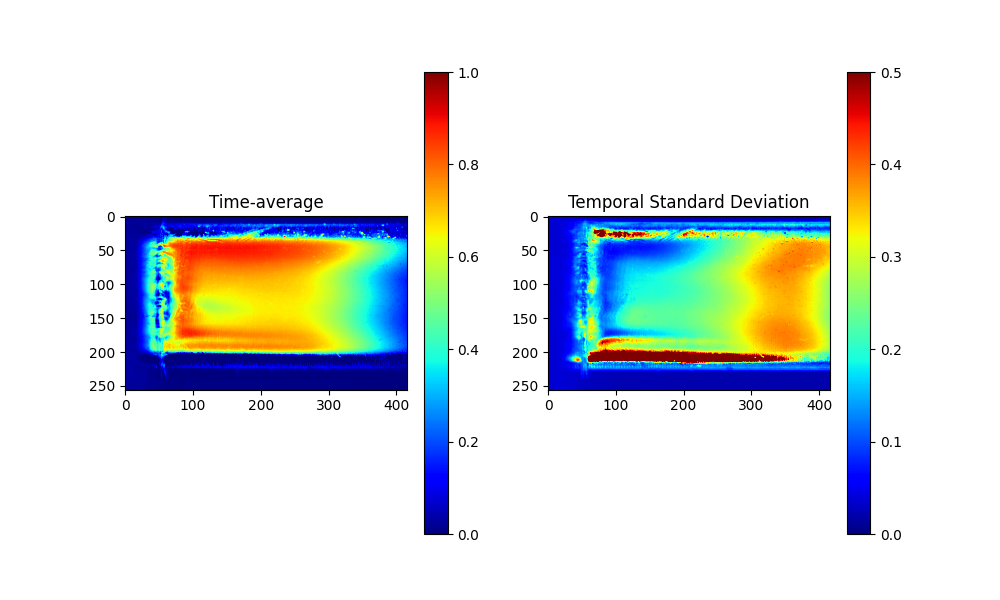

In [7]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
h=ax.imshow(timeAvImg,vmin=0,vmax=1,cmap='jet')
plt.title("Time-average")
plt.colorbar(h);

ax=fig.add_subplot(122)
h=ax.imshow(stdevImg,vmin=0,vmax=0.5,cmap='jet')
plt.title("Temporal Standard Deviation")
plt.colorbar(h);

In [8]:
gc.collect();

# Run the Welch Method
Time-Windowed Fourier Transform with detrending and Hann window with overlapping

In [9]:
# Apply Welch's method and then make contour plots of the results.
from scipy.signal import welch

nfft = 4096 # large enough to get the minimum frequency low enough.
noverlap = 32 # overlap segments per nfft to get good # of averages
print("Welch spectra:")
print(" - Ratio ensemble averages to N FFT points = %.2f" % (data.shape[0]/(nfft/noverlap)))
print(" - Num tasks =",data.shape[1])

def welchFun(I):
    # settings: 
    # linear detrending is ON
    # scaling output by power spectral density (variance of original signal)
    # Hann window and mean removal is applied to each fft.
    return welch(I, fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft, noverlap=int(nfft/float(noverlap)), nfft=nfft, detrend='linear',\
               return_onesided=True, scaling='density', axis=0, average='mean')

output = Parallel(n_jobs=1,verbose=10)(delayed(welchFun)(data[:,i,...]) for i in range(data.shape[1]))

Welch spectra:
 - Ratio ensemble averages to N FFT points = 234.37
 - Num tasks = 256


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   37.3s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  5.6min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 13.5min
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed: 13.8min
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed: 14.1min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 14.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 15.0min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed: 15.1min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 15.4min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed: 15.9min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed: 19.0min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed: 22.3min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed: 22.8min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed: 23.4min
[Parallel(n_jobs=1)]: Do

### Restructure the output
- The spectra go into Pxx[y][t,x]  which is a list of 2d arrays
- The frequency vector is f

- Use meshgrid to make 2D arrays of x and f for contour waterfall plots

In [10]:
f = output[0][0]
Pxx = [ output[i][1] for i in range(len(output)) ]
del output
del data
print(" - Frequency range = %f - %f Hz" % (f[1],f[-1]))

# Make x and f vectors for plotting
xx,ff=np.meshgrid(range(Pxx[0].shape[1]),f)
xx*=SPATIAL_RES
gc.collect();

 - Frequency range = 24.414062 - 50000.000000 Hz


## Transverse averaging
flatten everything in the Y axis.

This could involve masking out regions of the flow if required but in this case I just add up _all_ the spectra for each column and save into a single matrix 'zz'

In [11]:
zz = np.zeros_like(Pxx[0])
for i in range(len(Pxx)):
    zz += np.nan_to_num(Pxx[i])
zz /= float(i)
print("Y-averaged data range:",zz.min(),zz.max())

Y-averaged data range: 1.0279004e-08 0.00063975947


## Remove the background spectrum
Compare all spectra to a reference one.
- This removes any spectral influence from the light source, vibration of the camera, etc.
- In cavitation experiments, placing the reference spectrum upstream removes influence of incoming flow.

Orig. PSD magnitude range: 1.0279004e-08 to 0.00063975947
New   PSD magnitude range: 0.00049092394 to 3.1728265


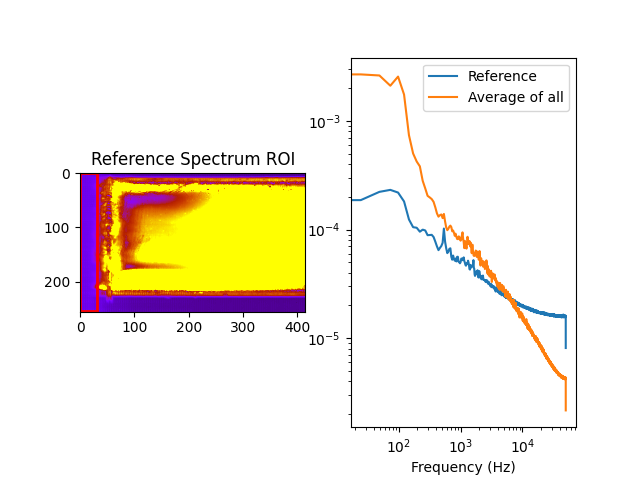

In [38]:
# Take average of some positions.
ref_y = (0,255)
ref_x = (0,30)

# Loop averaging in Y
bkgnd_spectrum = np.zeros_like(Pxx[0][:,0])
for i in range(ref_y[0],ref_y[1]):
    # Average in X
    bkgnd_spectrum += np.nanmean( Pxx[i][:,ref_x[0]:ref_x[1]], axis=1 )
bkgnd_spectrum /= abs(float(ref_y[1]-ref_y[0]))

# Normalise
integral = scipy.integrate.simpson(bkgnd_spectrum,x=f)
bkgnd_spectrum /= integral

# Average of all spectra to compare in plot
mean_spectrum = np.nanmean(zz,axis=1)
integral = scipy.integrate.simpson(mean_spectrum,x=f)
mean_spectrum /= integral

# Compute corrected spectrum and save it to 'zz2'
zz2 = np.zeros_like(zz)
for x_ in range(zz.shape[1]):
    zz2[:,x_] = zz[:,x_] / bkgnd_spectrum
print("Orig. PSD magnitude range:",zz.min(),"to",zz.max())
print("New   PSD magnitude range:",zz2.min(),"to",zz2.max())

# Show me where the reference is obtained
fig=plt.figure();
ax=fig.add_subplot(121)
h=ax.imshow(stdevImg,cmap=plt.cm.gnuplot,vmin=0,vmax=.2)
rect = matplotlib.patches.Rectangle((ref_x[0], ref_y[0]), ref_x[1]-ref_x[0], ref_y[1]-ref_y[0],\
                                    linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title("Reference Spectrum ROI");

ax=fig.add_subplot(122)
ax.loglog(f,bkgnd_spectrum,label='Reference')
ax.loglog(f,mean_spectrum,label='Average of all')
plt.xlabel('Frequency (Hz)');
plt.legend();

## Make graphs without the reference spectrum removed

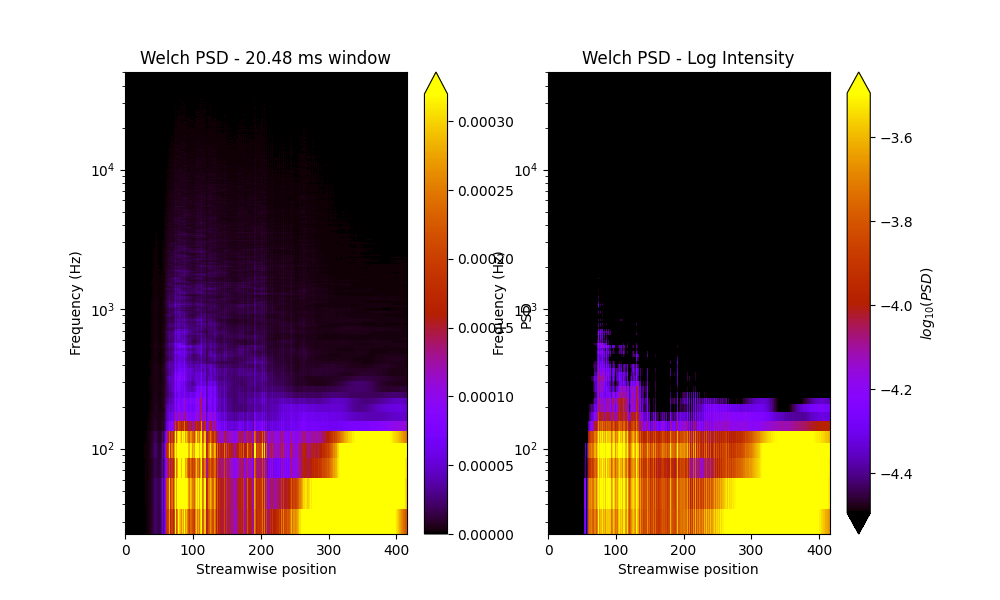

In [39]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)

vmin=0; vmax=zz.max()/2.

h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest',vmin=vmin,vmax=vmax)
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'PSD',extend='max')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE));

vmin=vmax/1e1

ax=fig.add_subplot(122)
logzz = np.log10(zz * (zz>1e-15) + 1e-15)
h=ax.pcolormesh(xx,ff,logzz,cmap=plt.cm.gnuplot,shading='nearest',vmin=np.log10(vmin),vmax=np.log10(vmax))
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$log_{10}(PSD)$',extend='both')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - Log Intensity');

## Make spectral plots with reference spectrum removed

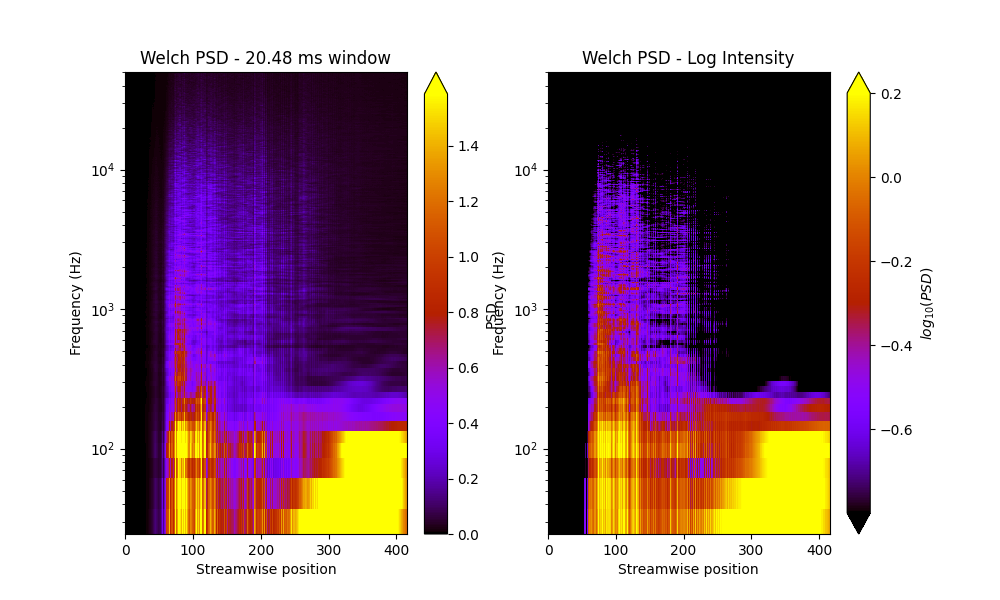

In [40]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)

vmin=0; vmax=zz2.max()/2.

h=ax.pcolormesh(xx,ff,zz2,cmap=plt.cm.gnuplot,shading='nearest',vmin=vmin,vmax=vmax)
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'PSD',extend='max')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE));

vmin=vmax/1e1

ax=fig.add_subplot(122)
logzz = np.log10(zz2 * (zz2>1e-15) + 1e-15)
h=ax.pcolormesh(xx,ff,logzz,cmap=plt.cm.gnuplot,shading='nearest',vmin=np.log10(vmin),vmax=np.log10(vmax))
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$log_{10}(PSD)$',extend='both')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - Log Intensity');

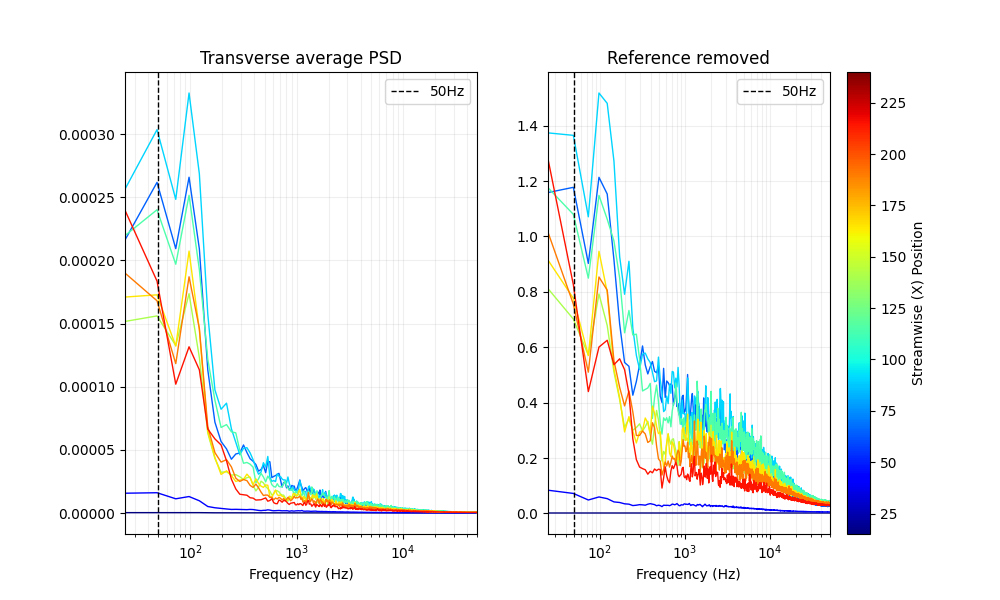

In [42]:
# Plot some selected FFTs

xpos = np.linspace(x.min()+1,x.max()-1,10) # positions
cm = plt.cm.jet#gnuplot

def make_line_plot(zz):
    for n in range(len(xpos)-1):
        # Set a range of positions to average over.
        x0=int(xpos[n]/SPATIAL_RES)
        x1=int((xpos[n+1]+1)/SPATIAL_RES)
        streamwise_avg=np.nanmean(zz[:,x0:x1],axis=1)
        p=ax.semilogx(f, streamwise_avg, label=None, lw=1,\
                    c=cm(float(n)/float(len(xpos)-1)))
    plt.grid(alpha=.2,which='both',axis='x')
    plt.grid(alpha=.2,which='major',axis='y')
    plt.axvline(50,ls='--',c='k',lw=1,label='50Hz')
    plt.xlabel('Frequency (Hz)')
    plt.legend();
    plt.xlim(f[f>0].min(),f.max());
    return
    
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
make_line_plot(zz)
plt.title("Transverse average PSD")

ax=fig.add_subplot(122)
make_line_plot(zz2)
plt.title("Reference removed")

xmid = (xpos[:-1] + xpos[1:])/2 # mid points
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(xmid.min(), xmid.max()))
plt.colorbar(sm,ax=ax,label=r'Streamwise (X) Position');
